# Part 5: Depth from Video -- Advanced

**Drawback:** The method relies on sufficient camera motion to recover accurate depths. If the camera motion is too small, the depth estimation could be less reliable.

**Method:** A possible solution is to use more robust feature matching methods that can handle large baselines, such as SIFT.


## New method
In the paper's *DISPARITY INITIALIZATION* part, the disparity likelihood is :
$$ L_{init}(x, d) = \sum_{t'} \rho_c(x, d, I_t, I_{t'})$$
Then I add a constraint $\rho_s$ to the likelihood, so the modified likelihood is :
$$ L_{init}(x, d) = \sum_{t'} \rho_c(x, d, I_t, I_{t'}) \rho_s(x, d, P_{t-t'}) $$
where
$ P_{t->t'} $is the SIFT keypoints from image t to image t' after RANSAC
and $$\rho_s(x, d, P_{t-t'}) = exp(- \frac{|x' - P_{t->t'}(x)| ^2}{ 2\sigma_s^2})$$
in the form of a Gaussian distribution, where $\sigma_d$ denotes the standard deviation. When the x' is closer to the x corresponding SIFT keypoint's location in image t', the value of $\rho_s$ will larger.

In [4]:
import gco.pygco as pygco
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from tqdm.notebook import tqdm

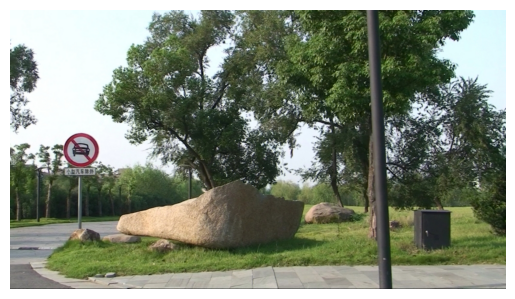

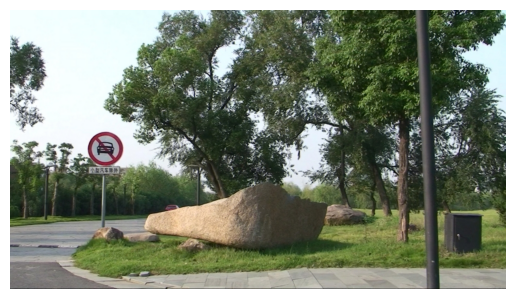

In [2]:
im01 = cv2.imread('part3_images/test00.jpeg')
im01 = cv2.cvtColor(im01, cv2.COLOR_BGR2RGB)
plt.imshow(im01)
plt.axis('off')
plt.show()

im02 = cv2.imread('part3_images/test09.jpeg')
im02 = cv2.cvtColor(im02, cv2.COLOR_BGR2RGB)
plt.imshow(im02)
plt.axis('off')
plt.show()

In [3]:
sift = cv2.SIFT_create()

im01_gray = cv2.cvtColor(im01, cv2.COLOR_BGR2GRAY)
im02_gray = cv2.cvtColor(im02, cv2.COLOR_BGR2GRAY)


kp1, des1 = sift.detectAndCompute(im01_gray, None)
kp2, des2 = sift.detectAndCompute(im02_gray, None)

line1 = cv2.drawKeypoints(im01, kp1, im01, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
line2 = cv2.drawKeypoints(im02, kp2, im02, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

In [14]:
def match(des1, des2):
    best1 = np.zeros(des1.shape[0])
    best2 = np.zeros(des2.shape[0])

    for i in range(des1.shape[0]):
        distant = np.zeros(des2.shape[0])
        for j in range(des2.shape[0]):
            distant[j] = np.sum((des1[i] - des2[j]) ** 2)
        best1[i] = int(np.argmin(distant))
    
    for i in range(des2.shape[0]):
        distant = np.zeros(des1.shape[0])
        for j in range(des1.shape[0]):
            distant[j] = np.sum((des2[i] - des1[j]) ** 2)       
        best2[i] = int(np.argmin(distant))
    
    best1 = best1.astype(int)
    best2 = best2.astype(int)

    matches = []
    for i in range(best1.shape[0]):
        m = best1[i]
        n = best2[m]
        if i == n:
            matches.append([n, m])
            
    return matches

In [15]:
def matchesLines(im01, im02, matches):
    imgs_matches = np.concatenate((im01,im02),axis = 1)
    colors = [
        (255, 0, 0),     
        (0, 255, 0),     
        (0, 0, 255),     
        (255, 255, 0),   
        (255, 0, 255),   
        (0, 255, 255),   
        (128, 128, 128), 
        (0, 0, 0),       
        (255, 255, 255)  
    ]

    for i in range(len(matches)):
        x1 = kp1[int(matches[i][0])].pt[0]
        y1 = kp1[int(matches[i][0])].pt[1]
        x2 = kp2[int(matches[i][1])].pt[0]
        y2 = kp2[int(matches[i][1])].pt[1]
        color_idx = random.randint(0,8)
        cv2.line(imgs_matches,(int(x1),int(y1)),(int(x2)+im01.shape[1],int(y2)),colors[color_idx],1)
    
    plt.imshow(imgs_matches)
    plt.axis('off')
    plt.show()

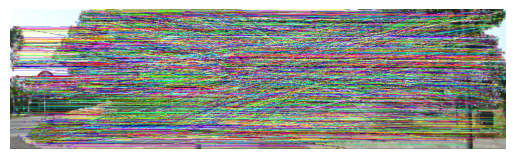

In [7]:
matches = match(des1, des2)
matchesLines(im01, im02, matches)

In [16]:
def homography(points_1, points_2):
    points_1 = np.column_stack((points_1, np.ones(len(points_1))))
    points_2 = np.column_stack((points_2, np.ones(len(points_2))))

    A = np.zeros((2*len(points_1),9))
    for i in range(len(points_1)):
        x1, y1, _ = points_1[i]
        x2, y2, _ = points_2[i]
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2]
        A[2*i + 1] = [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]

    U, D, V_T = np.linalg.svd(A)
    h = V_T[-1]
    H = h.reshape((3,3))
    H = H / H[2,2]
    return H

In [17]:

def RANSAC_homography(kp1, kp2, matches, iteration_times):
    n = 5
    final_H = []
    epsion = 5 # threshold of the distance of inliers
    N = len(matches)
    max_inliers = []
    
    for k in range(iteration_times):
        rdm = random.sample(range(0, N), 5)
        points_1 = []
        points_2 = []
        for j in range(n):
            points_1.append([kp1[int(matches[rdm[j]][0])].pt[0], kp1[int(matches[rdm[j]][0])].pt[1]])
            points_2.append([kp2[int(matches[rdm[j]][1])].pt[0], kp2[int(matches[rdm[j]][1])].pt[1]])

        H = homography(points_1, points_2)
        
        inliers = []
        
        for i in range(N):
            x1 = kp1[int(matches[i][0])].pt[0]
            y1 = kp1[int(matches[i][0])].pt[1]
            x2 = kp2[int(matches[i][1])].pt[0]
            y2 = kp2[int(matches[i][1])].pt[1]
            
            hx1, hy1, hz1 = np.dot(H, [x1, y1, 1])
            hx1 = int(hx1 / hz1)
            hy1 = int(hy1 / hz1)
            distance = np.sqrt((x2 - hx1) ** 2 + (y2 - hy1) ** 2)

            if distance < epsion:
                inliers.append(matches[i])
        
        if len(inliers) > len(max_inliers):
            max_inliers = inliers

    '''
    points_1 = []
    points_2 = []
    for i in range(len(max_inliers)):
        points_1.append([kp1[int(max_inliers[i][0])].pt[1], kp1[int(max_inliers[i][0])].pt[0]])
        points_2.append([kp2[int(max_inliers[i][1])].pt[1], kp2[int(max_inliers[i][1])].pt[0]])
    final_H = homography(points_1, points_2) 
    '''
    return max_inliers

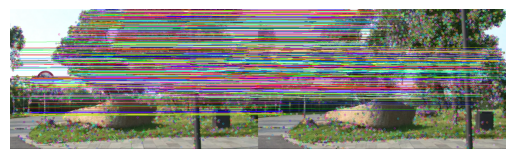

In [21]:
inliers = RANSAC_homography(kp1, kp2, matches, 1000)
matchesLines(im01, im02, inliers)

In [6]:
# Load camera matrices
num_frame = int(np.loadtxt('Road/cameras.txt',dtype=np.float32, max_rows=1))
cam = np.loadtxt('Road/cameras.txt',dtype=np.float32, skiprows=1)
K = []
R = []
T = []
for i in range(num_frame):
    K.append(cam[7*i : 7*i + 3, :])
    R.append(cam[7*i + 3 : 7*i +6, :])
    T.append(cam[7*i + 6, :])
K = np.array(K)
R = np.array(R)
T = np.array(T)

In [7]:
# Load images
image_folder = 'D:\\ai\mnist-cnn\\5731\ca2\Road\src'

images = []

for item in os.listdir(image_folder):
    image_path = os.path.join(image_folder, item)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

images = np.array(images)

In [21]:
# some basic functions
def color_L2_norm(p1, p2):
    return np.linalg.norm(p1-p2)

def compute_xInfinity(x, K1, R1, K2, R2):
        x_infinity = K2 @ R2.T @ R1 @ np.linalg.inv(K1) @ x
        return x_infinity

def compute_ePrime(T1, T2, K2, R2):
        e_prime = K2 @ R2.T @ (T1.T - T2.T)
        return e_prime

## Disparity Initialization

In [ ]:
class Dinit():
    def __init__(self, frames, K, R, T):
        self.N = frames.shape[0] # number of frames
        self.frames = frames
        self.H, self.W = frames[0].shape[:2]

        # the camera matrix of the seleted frames
        self.K = K
        self.R = R
        self.T = T

        # some hyper-parameters
        self.number_D = None          # the number of disparity candidates
        self.sigma_c = None                   # the shape of the differentiable robust function in the fd equation
        self.disparity_candidates = None    # the dmin ~ dmax candidates
        self.Ws = None                      # the smoothness strength in the fp equation
        self.Epsilon = None                 # the contrast sensitivity in the fp equation
        self.Eta = None                     # the upper limit of the cost in the fp equation
        self.sigma_s = None

    def depth_maps(self):
        depth_maps_init = np.zeros((self.N, self.H, self.W))
        for t in range(self.N):
            data_term = self.compute_fd(t)
            fp, edges, edge_weights = self.compute_prior(self,t)
            depth_map = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
            depth_maps_init[t] = depth_map
        return depth_maps_init


    def set_parameters(self,sigma_c, Ws, disparity_candidates, Eta, Epsilon, sigma_s):
        self.sigma_c = sigma_c
        self.Ws = Ws
        self.disparity_candidates = disparity_candidates
        self.number_D = len(disparity_candidates)
        self.Eta = Eta
        self.Epsilon = Epsilon
        self.sigma_s = sigma_s


    def one_map(self, t): #t: the selected frame  只跑一张图
        disparity_map_init = np.zeros((self.H, self.W))
        data_term = self.compute_fd(t)
        fp, edges, edge_weights = self.compute_prior(t)
        disparity_map_init = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp, algorithm='swap').reshape(self.H, self.W)
        return disparity_map_init


    def compute_fd(self, t,save=True):
        #It = self.frames[t]
        fd = np.zeros((self.H, self.W, self.number_D))
        K1 = self.K[t]
        R1 = self.R[t]
        T1 = self.T[t]
        other_frames_idx = [a for a in range(self.N) if a != t]

        for t_prime in other_frames_idx:
            #It_prime = self.frames[t_prime]
            K2 = self.K[t_prime]
            R2 = self.R[t_prime]
            T2 = self.T[t_prime]

            likelihood = self.compute_likelihood(t, t_prime, K1=K1, R1=R1, T1=T1, K2=K2, R2=R2, T2=T2)
            fd += likelihood
        Ux = 1/np.max(fd)
        data_term = 1 - Ux * fd
        data_term = data_term.reshape(data_term.shape[0] * data_term.shape[1] , data_term.shape[2])
        if save:
            np.save(f'data_terms/part5_Dinit_frame_{t}.npy', data_term)
            print(f'part5_Dinit_frame_{t}.npy saved')
        return data_term


    def compute_prior(self, t):
        It = self.frames[t]
        fp = np.zeros((self.number_D, self.number_D))  # pairwise
        for i in range(self.number_D):
            for j in range(self.number_D):
                fp[i][j] = min(abs(self.disparity_candidates[i] - self.disparity_candidates[j]), self.Eta)

        edges = []
        edge_weights = []

        for y in range(self.H):
            for x in range(self.W):
                color_differences = []
                node1 = y * self.W + x
                Nx = 0                  #number of neighbors
                Ux_down = 0
                if x-1>0:  # the up neighbor
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y][x-1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x-1
                    edges.append([node1, node2])
                if x+1 < self.W:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y][x+1])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = y * self.W + x + 1
                    edges.append([node1, node2])
                if y-1>0:
                    Nx +=1
                    color_difference = color_L2_norm(It[y][x], It[y-1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y-1) * self.W + x
                    edges.append([node1, node2])
                if y+1 < self.H:
                    Nx += 1
                    color_difference = color_L2_norm(It[y][x], It[y+1][x])
                    color_differences.append(color_difference)
                    Ux_down += 1 / (color_difference + self.Epsilon)
                    node2 = (y+1) * self.W + x
                    edges.append([node1, node2])

                for neighbor in range(Nx):
                    weight = Nx / ((color_differences[neighbor] + self.Epsilon) * Ux_down)
                    edge_weights.append(weight)
        return self.Ws * fp, np.array(edges), np.array(edge_weights)


    def compute_likelihood(self, t, t_prime, K1, R1, T1, K2, R2, T2):
        It = self.frames[t]
        It_prime = self.frames[t_prime]
        e_prime = compute_ePrime(T1, T2, K2, R2)
        points_1, points_2 = self.transform_points(It, It_prime)
        print(points_1)
        points_1_dict = {(x, y): i for i, (x, y) in enumerate(points_1)}  # point: key
        print(points_1_dict)
        points_2_dict = {i: point for i, point in enumerate(points_2)}     # key: point
        IF_RHO_s = False
        likelihood = np.zeros((self.H, self.W, self.number_D))
        expression = K2 @ R2.T @ R1 @ np.linalg.inv(K1)
        for y in tqdm(range(self.H), desc='Processing Y from 0 to 540', leave=True):
            for x in range(self.W):
                index_sift = points_1_dict.get((x,y))
                if index_sift:
                    p1_homo = np.array(points_2_dict.get(index_sift))
                    IF_RHO_s = True
                    print(1)
                for d in range(self.number_D):
                    x_h = np.array([x, y, 1])
                    #x_infinity = compute_xInfinity(x_h, K1=K1, R1=R1, K2=K2, R2=R2).reshape(3, 1)
                    x_h_prime = expression @ x_h + self.disparity_candidates[d]*e_prime
                    x_h_prime = x_h_prime * (1.0 / x_h_prime[2]) # normalize

                    # Whether the x_h_prime in the frame t_prime
                    x_h_prime[0] = min(max(0, x_h_prime[0]), self.W-1)
                    x_h_prime[1] = min(max(x_h_prime[1], 0), self.H-1)
                    x_h_prime = x_h_prime.astype(int)

                    p1 = It[y, x]
                    p2 = It_prime[x_h_prime[1], x_h_prime[0]]
                    # compute rho_c for that pixel
                    rho_c = self.sigma_c / (self.sigma_c + color_L2_norm(p1, p2))
                    if IF_RHO_s:
                        rho_s = self.compute_rho_s(p1_homo,  x_h_prime[0], x_h_prime[1])
                        likelihood[y][x][d] = rho_c * rho_s
                    else:
                        likelihood[y][x][d]= rho_c
        return likelihood

    def transform_points(self, im01, im02):
        im01_gray = cv2.cvtColor(im01, cv2.COLOR_BGR2GRAY)
        im02_gray = cv2.cvtColor(im02, cv2.COLOR_BGR2GRAY)

        kp1, des1 = sift.detectAndCompute(im01_gray, None)
        kp2, des2 = sift.detectAndCompute(im02_gray, None)

        matches = match(des1, des2)
        inliers = RANSAC_homography(kp1, kp2, matches, 1000)
        points_1 = []
        points_2 = []
        for i in range(len(inliers)):
            x1 = int(kp1[int(inliers[i][0])].pt[0])
            y1 = int(kp1[int(inliers[i][0])].pt[1])
            x2 = int(kp2[int(inliers[i][1])].pt[0])
            y2 = int(kp2[int(inliers[i][1])].pt[1])
            points_1.append([x1, y1])
            points_2.append([x2, y2])
        return points_1, points_2

    def compute_rho_s(self, p1_homo, p20, p21):
        norm = (p1_homo[0]-p20)**2 + (p1_homo[1]-p21)**2
        return np.exp(-norm / (2*self.sigma_s**2))


In [29]:
# some parameters
N = 5 # the number of frames
sigma_c = 10 #
sigma_s = 1
number_D = 50 # the number of disparity candidate of each frame
disparity_candidates = np.linspace(0, 0.05, number_D +1)
disparity_candidates = disparity_candidates[1:]
Epsilon = 50
Ws = 500
Eta = 0.5
frames = images[0:N]
K_frames= K[0:N]
R_frames = R[0:N]
T_frames = T[0:N]
H, W = images[0].shape[:2] # the height and width, because all images have same size, so only need compute once
sift = cv2.SIFT_create()

In [22]:
initMaps = Dinit(frames=frames,K=K_frames,R=R_frames,T=T_frames)
initMaps.set_parameters(sigma_c=sigma_c,Ws=Ws, disparity_candidates=disparity_candidates,Eta=Eta,Epsilon=Epsilon,sigma_s=sigma_s)
init_map_1 = initMaps.one_map(1)

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

Processing Y from 0 to 540:   0%|          | 0/540 [00:00<?, ?it/s]

part5_Dinit_frame_1.npy saved


TypeError: compute_prior() takes 2 positional arguments but 3 were given

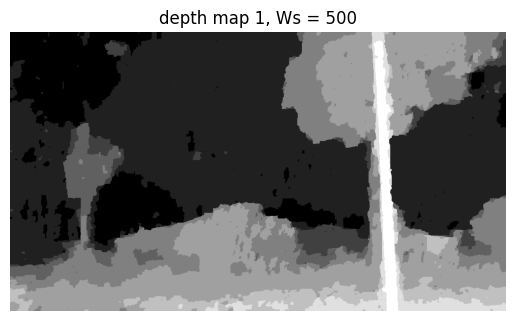

In [26]:
data_term = np.load('data_terms/part5_Dinit_frame_1.npy')
initMaps = Dinit(frames=frames,K=K_frames,R=R_frames,T=T_frames)
initMaps.set_parameters(sigma_c=sigma_c,Ws=Ws, disparity_candidates=disparity_candidates,Eta=Eta,Epsilon=Epsilon,sigma_s=sigma_s)
fp, edges, edge_weights = initMaps.compute_prior(1)
init_map_1 = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(init_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()

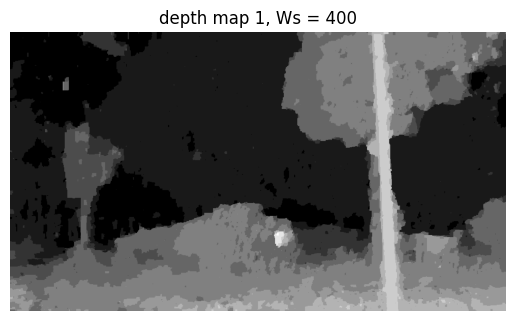

In [27]:
initMaps.Ws = 400
fp, edges, edge_weights = initMaps.compute_prior(1)
init_map_1 = pygco.cut_general_graph(edges=edges, edge_weights=edge_weights, unary_cost=data_term, pairwise_cost=fp,algorithm='swap').reshape(H, W)
plt.imshow(init_map_1, cmap='gray')
plt.title(f'depth map 1, Ws = {initMaps.Ws}')
plt.axis('off')
plt.show()